In [7]:
#Problem -  Design and develop a Machine learning model that can help in making predictions that may be useful for doctors and healthcare providers 
#to predict potential heart disease cases early on. Use below dataset to predict which patients are most likely to suffer from a heart disease 
#in the near future using the features given.

#Data Exploration: Understanding the dataset and key features.
#Data Preprocessing: Cleaning the data, handling missing values, and normalizing features.
#Modeling: Implementing and evaluating machine learning model - Logistic Regression
#Evaluation: Evaluate your model 

import os
import sys
import textwrap
from typing import List, Tuple

import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve,
    roc_curve, confusion_matrix, classification_report, brier_score_loss)
import matplotlib.pyplot as plt
from joblib import dump


#Load dataset - heart.csv

heart_disease = pd.read_csv("heart.csv")


In [6]:
#Data Exploration: Understanding the dataset and key features

print(heart_disease.head())       

print(heart_disease.info())       # shows column names and data types
print(heart_disease.describe())   # summary statistics
      

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   0     3       0  
3   1     3       0  
4   3     2       0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 

In [9]:
print("Shape:", heart_disease.shape)

Shape: (1025, 14)


In [10]:
# check missing values in each column

print("\nMissing values per column:")
display(heart_disease.isna().sum().sort_values(ascending=False))


Missing values per column:


age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [13]:
# Check distribution of data if roughly 50% "1" and 50% "0" 

if "target" in heart_disease.columns:
    print("\nTarget (counts):")
    print(heart_disease["target"].value_counts(dropna=False))
    print("\nTarget (proportions):")
    print((heart_disease["target"].value_counts(normalize=True) * 100).round(2).astype(str) + "%")



Target (counts):
target
1    526
0    499
Name: count, dtype: int64

Target (proportions):
target
1    51.32%
0    48.68%
Name: proportion, dtype: object


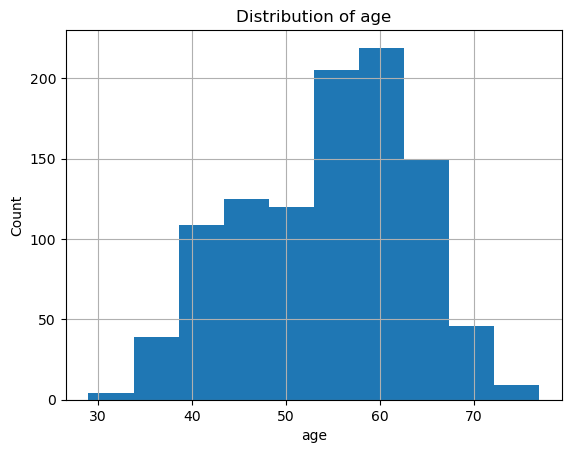

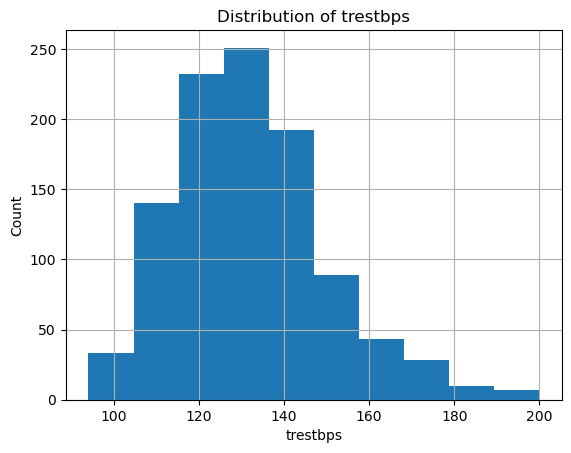

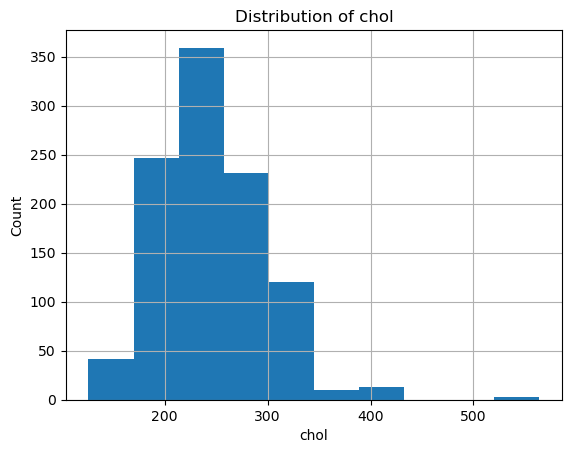

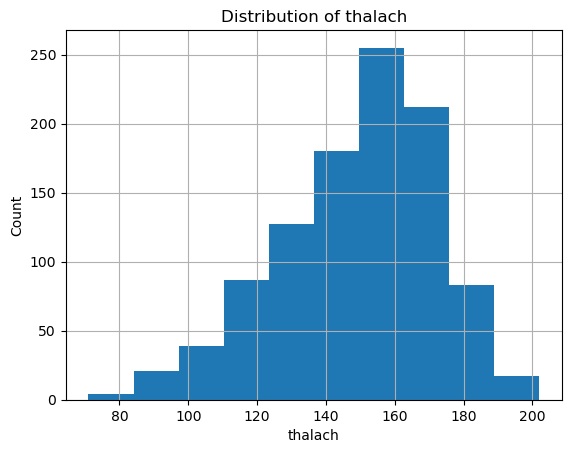

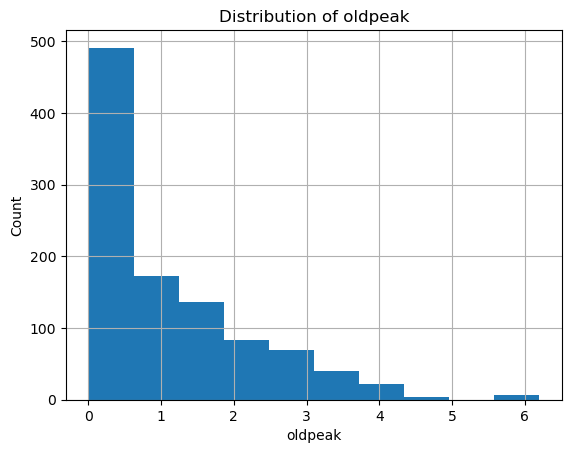

In [15]:
# Plot quick histograms for numeric features

numeric_preview_cols = ["age","trestbps","chol","thalach","oldpeak"	]
for col in numeric_preview_cols:
    if col in heart_disease.columns:
        heart_disease[col].hist()
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.show()

In [18]:
# Data Preprocessing 

# check if missing columns

expected_columns = [  
            "age",	"sex",	"cp",	"trestbps",	"chol",	"fbs",	"restecg",	"thalach",	"exang",	"oldpeak",	"slope",	"ca",	"thal",	"target",
]
present = [c for c in expected_columns if c in heart_disease.columns]
missing = [c for c in expected_columns if c not in heart_disease.columns]
print("Columns present:", present)
print("Columns missing:", missing)

Columns present: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
Columns missing: []


In [29]:
# check if missing 'source of truth'

if "target" not in heart_disease.columns:
    raise ValueError("The dataset must contain a 'target' column (1 = disease, 0 = no disease).")

feature_columns = [c for c in present if c != "target"]
X = heart_disease[feature_columns].copy()
y = heart_disease["target"].copy()

#age	sex	cp	trestbps	chol	fbs	restecg	thalach	exang	oldpeak	slope	ca	thal	target

categorical_columns = [c for c in [
    "sex", "cp", "fbs",
    "restecg", "exang", "slope", "ca", "thal"
] if c in X.columns]

numeric_columns = [c for c in X.columns if c not in categorical_columns]

print("\nNumeric columns:", numeric_columns)
print("Categorical columns:", categorical_columns)


Numeric columns: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
Categorical columns: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']


In [32]:
# Preprocessing 
# Impute missing data and Normalizing features

numeric_tf = Pipeline(steps=[
    ("Impute", SimpleImputer(strategy="median")),
    ("Normalize", StandardScaler())
])
categorical_tf = Pipeline(steps=[
    ("Impute", SimpleImputer(strategy="most_frequent")),
    ("Onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_tf, numeric_columns),
        ("cat", categorical_tf, categorical_columns),
    ],
    remainder="drop"
)

# Train Test set split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train.shape, X_test.shape

((820, 13), (205, 13))

In [36]:
# Modeling — Logistic Regression
#   class_weight='balanced' for potential imbalance
#   5-fold CV ROC AUC on train
# ============================================

classifier = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear"))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring="roc_auc")
print("CV ROC AUC (train):", np.round(cv_scores, 4))
print("Mean ± std:", round(cv_scores.mean(), 4), "±", round(cv_scores.std(), 4))

# Fit on full training set
classifier.fit(X_train, y_train)



CV ROC AUC (train): [0.9228 0.9275 0.9354 0.9524 0.9363]
Mean ± std: 0.9349 ± 0.0101


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('Impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('Normalize',
                                                                   StandardScaler())]),
                                                  ['age', 'trestbps', 'chol',
                                                   'thalach', 'oldpeak']),
                                                 ('cat',
                                                  Pipeline(steps=[('Impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('Onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'cp', 'fbs',
                                                   'restecg', 'exang', 'slope',
                                                   'ca', 'thal'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    solver='liblinear'))])

Test Metrics
------------
ROC AUC: 0.9441
PR  AUC: 0.9324
Brier : 0.0901

Classification Report (threshold=0.5)
              precision    recall  f1-score   support

           0      0.894     0.840     0.866       100
           1      0.856     0.905     0.880       105

    accuracy                          0.873       205
   macro avg      0.875     0.872     0.873       205
weighted avg      0.874     0.873     0.873       205



,Pred 0,Pred 1
Actual 0,84,16
Actual 1,10,95


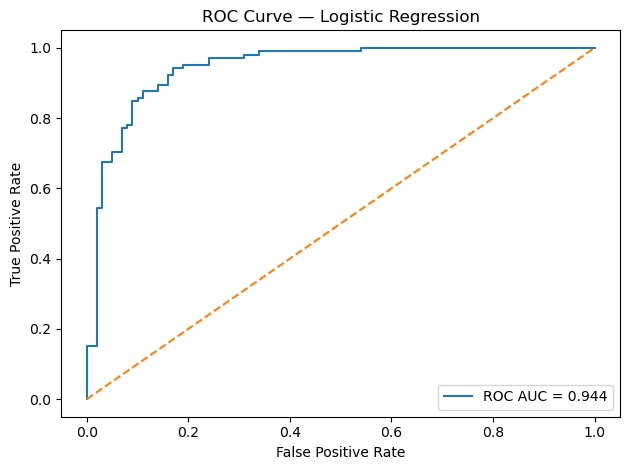

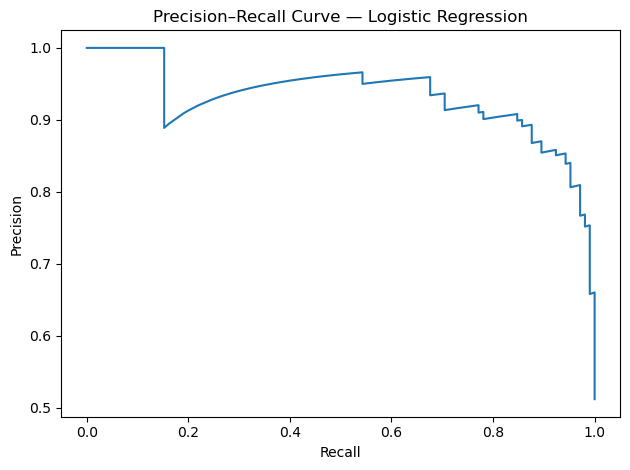

In [38]:
# ============================================
# Model evaluation 
# ============================================

# Probabilities and default threshold
y_proba = clf.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

# Metrics
roc_auc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)
brier = brier_score_loss(y_test, y_proba)

print("Test Metrics")
print("------------")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR  AUC: {pr_auc:.4f}")
print(f"Brier : {brier:.4f}\n")

print("Classification Report (threshold=0.5)")
print(classification_report(y_test, y_pred, digits=3))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Pred 0", "Pred 1"])
display(cm_df)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Logistic Regression")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Precision-Recall Curve
prec, rec, thr = precision_recall_curve(y_test, y_proba)
plt.figure()
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve — Logistic Regression")
plt.tight_layout()
plt.show()